## Quantum energy teleportation protocol with minimal model

### Import packages

In [23]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister
from qiskit import transpile

from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2 as sampler
from qiskit.visualization import plot_histogram

### Function to generate a circuit that measures the interaction term $X_0X_1$ or $V$

In [24]:
def qc_V(h,k):

    # Create circuit
    qr = QuantumRegister(2)
    qc = QuantumCircuit(qr)
    
    #Prepare the ground state
    theta = -np.arcsin((1/np.sqrt(2))*(np.sqrt(1+h/np.sqrt(h**2+k**2))))

    qc.ry(2*theta,qr[0])
    qc.cx(qr[0],qr[1])

    qc.barrier()

    # Projective measurement of A
    qc.h(qr[0])

    qc.barrier()

    # Condicional operation on B
    phi = 0.5*np.arcsin((h*k)/np.sqrt((h**2+2*k**2)**2+(h*k)**2))

    qc.cry(-2*phi,qr[0],qr[1])

    qc.x(qr[0])
    qc.cry(2*phi,qr[0],qr[1])
    qc.x(qr[0])

    # Measurement of the interaction term V
    qc.h(qr[1])
    qc.measure_all()

    return qc


### Function to generate a circuit that measures the local term $Z_1$ or $H_1$

In [25]:
def qc_H(h,k):

    # Generate circuit
    qr = QuantumRegister(2)
    qc = QuantumCircuit(qr)

    #Prepare the ground state
    theta = -np.arcsin((1/np.sqrt(2))*(np.sqrt(1+h/np.sqrt(h**2+k**2))))

    qc.ry(2*theta,qr[0])
    qc.cx(qr[0],qr[1])
    
    qc.barrier()

    # Projective measurement on A
    qc.h(qr[0])

    qc.barrier()

    # Condicional operation on B
    phi = 0.5*np.arcsin((h*k)/np.sqrt((h**2+2*k**2)**2+(h*k)**2))

    qc.cry(-2*phi,qr[0],qr[1])
    
    qc.x(qr[0])
    qc.cry(2*phi,qr[0],qr[1])
    qc.x(qr[0])

    # measurement of Bob's Z term
    qc.measure_all()

    return qc

### Show quantum circuit

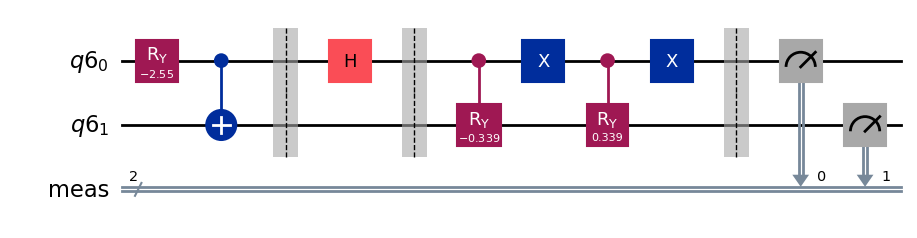

In [26]:
qc = qc_H(1.5, 1)
qc.draw('mpl')

### Simulate circuit $V$ with aer simulator

In [27]:
# Initiate simulator
simulator = AerSimulator()

# Parameters
h = 1.5; k = 1;
n_shots = 100000

# Generate circuit
qc = qc_V(h, k)
qc_A = transpile(qc, simulator, optimization_level=3)

# Run job with Sampler
jobA_sim = sampler().run([qc_A], shots=n_shots)

### Simulate circuit H with aer simulator

In [28]:
# Initiate simulator
simulator = AerSimulator()

# Parameters
h = 1.5; k = 1;
n_shots = 100000

# Generate circuit
qc = qc_H(h, k)
qc_B = transpile(qc, simulator, optimization_level=3)

# Run job with Sampler
jobB_sim = sampler().run([qc_B], shots=n_shots)

### Show results for simulated circuit V

Theoric energy injected by Alice 1.2480754415067656
Experimental energy injected by Alice 1.2422854415067657 ± 0.00474338115261677
Interacting energy, V = -0.49107960754954166 ± 0.006324503194401912


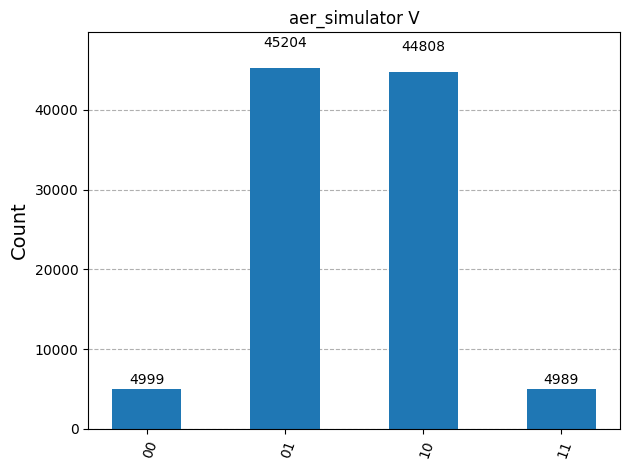

In [29]:
# Extract results
result = jobA_sim.result()[0]
counts = result.data.meas.get_counts()

# Energies
ene_A = (h**2)/(np.sqrt(h**2+k**2))
ene_V = (2*k**2)/(np.sqrt(h**2+k**2))

# Error arrays
error_A = []
error_V = []

# Calculate energies
for orig_bit_string, count in counts.items():
        bit_string = orig_bit_string[::-1]

        ene_A += h*(-1)**int(bit_string[0])*count/n_shots
        ene_V += 2*k*(-1)**int(bit_string[0])*(-1)**int(bit_string[1])*count/n_shots

        for i in range(count):
            error_A.append(h*(-1)**int(bit_string[0]))
            error_V.append(2*k*(-1)**(int(bit_string[1])))

# Print results
print("Theoric energy injected by Alice",h**2/np.sqrt(h**2+k**2))
print("Experimental energy injected by Alice",ene_A,"±",np.std(error_A)/np.sqrt(n_shots))
print("Interacting energy, V =",ene_V,"±",np.std(error_V)/np.sqrt(n_shots))

plot_histogram(counts, title='aer_simulator V')

### Show results for simulated circuit $H$

Theoric energy injected by Alice 1.2480754415067656
Experimental energy injected by Alice 1.2441454415067654 ± 0.0047434002098705515
Bob's local energy, H_B = 0.34615544150676547 ± 0.00379017191377911


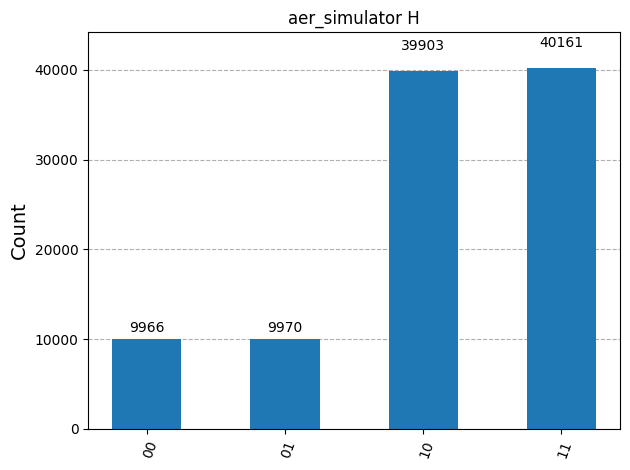

In [30]:
# Extract results
result = jobB_sim.result()[0]
counts = result.data.meas.get_counts()

# Energys
ene_A = (h**2)/(np.sqrt(h**2+k**2))
ene_B = (h**2)/(np.sqrt(h**2+k**2))

# Error arrays
error_A = []
error_B = []

# Calculate energies and errors
for orig_bit_string, count in counts.items():
        bit_string = orig_bit_string[::-1]

        ene_B += h*(-1)**int(bit_string[1])*count/n_shots
        ene_A += h*(-1)**int(bit_string[0])*count/n_shots

        for i in range(count):
            error_A.append(h*(-1)**int(bit_string[0]))
            error_B.append(h*(-1)**int(bit_string[1]))

# Print results
print("Theoric energy injected by Alice",h**2/np.sqrt(h**2+k**2))
print("Experimental energy injected by Alice",ene_A,"±",np.std(error_A)/np.sqrt(n_shots))
print("Bob's local energy, H_B =",ene_B,"±",np.std(error_B)/np.sqrt(n_shots))

plot_histogram(counts, title="aer_simulator H")

### Get backend and its properties

In [31]:
# Log in IBM platoform
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService()

# Select least busy backend
backend = service.least_busy(operational=True)

# Get backend properties
props = backend.properties()

# Function to select specific properties
def describe_qubit(qubit, properties):
    """Print a string describing some of reported properties of the given qubit."""

    # Conversion factors from standard SI units
    us = 1e6
    ns = 1e9
    GHz = 1e-9

    print("Backend = {6}\n"
          "Qubit {0} has a \n"
          "  - T1 time of {1} microseconds\n"
          "  - T2 time of {2} microseconds\n"
          "  - U2 gate error of {3}\n"
          "  - U2 gate duration of {4} nanoseconds\n"
          "  - resonant frequency of {5} GHz".format(
              qubit,
              properties.t1(qubit) * us,
              properties.t2(qubit) * us,
              properties.gate_error('sx', qubit),
              properties.gate_length('sx', qubit) * ns,
              properties.frequency(qubit) * GHz,
              backend.name))

describe_qubit(0, props)

Backend = ibm_kyiv
Qubit 0 has a 
  - T1 time of 449.4431808883927 microseconds
  - T2 time of 409.8796962682189 microseconds
  - U2 gate error of 0.00010929068140861103
  - U2 gate duration of 49.77777777777777 nanoseconds
  - resonant frequency of 4.655632254676594 GHz


### Run job in IBM Backend

In [ ]:
# Import Sampler and Batch mode
from qiskit_ibm_runtime import Batch, SamplerV2 as sampler

# Parameters h and k
variables = [(1,0.2),(1,0.5),(1,1),(1.5,1)]

#  Run job in Batch mode
with Batch(backend=backend):
    n_shots = 5000

    for variable in variables:
        h = variable[0]
        k = variable[1]

        # Generate circuits V and H
        circuit_V = qc_V(h,k)
        qc_A = transpile(circuit_V, backend=backend, optimization_level=3)
        
        circuit_H = qc_H(h,k)
        qc_B = transpile(circuit_H, backend=backend, optimization_level=3)

        # Run jobs for each circuit
        job_A = sampler().run([(qc_A)], shots=n_shots)
        print("Circuit V","ID =",job_A.job_id(), "h =",h, "k =",k)

        job_B = sampler().run([(qc_B)], shots=n_shots)
        print("Circuit H","ID =",job_B.job_id(), "h =",h, "k =",k) 

### Show results for circuit V

Theoric energy injected by Alice 1.2480754415067656
Experimental energy injected by Alice 1.1736754415067658 ± 0.02118709342972745
Interacting energy, V = -0.4577996075495418 ± 0.028268678922086187


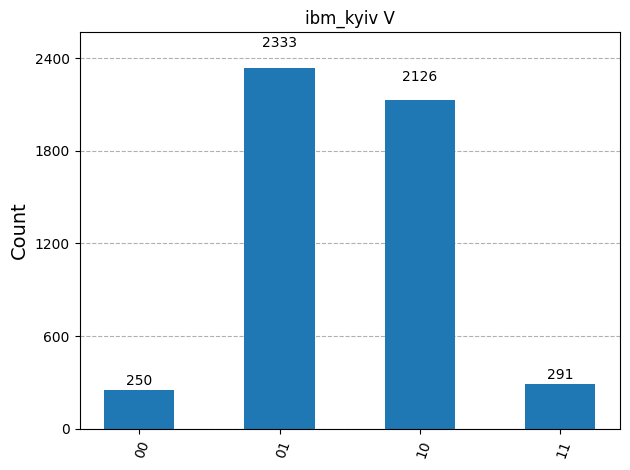

In [37]:
# Extract results
jobA = service.job('czzxtybnhqag008v1a7g')
result = jobA.result()[0]
counts = result.data.meas.get_counts()

# Parameters 
k = 1;h = 1.5;
n_shots = 5000

# Energies
ene_A = (h**2)/(np.sqrt(h**2+k**2))
ene_V = (2*k**2)/(np.sqrt(h**2+k**2))

# Erros arrays
error_A = []
error_V = []

# Calculate energies and errors
for orig_bit_string, count in counts.items():
        bit_string = orig_bit_string[::-1]

        ene_A += h*(-1)**int(bit_string[0])*count/n_shots
        ene_V += 2*k*(-1)**int(bit_string[0])*(-1)**int(bit_string[1])*count/n_shots

        for i in range(count):
            error_A.append(h*(-1)**int(bit_string[0]))
            error_V.append(2*k*(-1)**(int(bit_string[1])))

# Print results
print("Theoric energy injected by Alice",h**2/np.sqrt(h**2+k**2))
print("Experimental energy injected by Alice",ene_A,"±",np.std(error_A)/np.sqrt(n_shots))
print("Interacting energy, V =",ene_V,"±",np.std(error_V)/np.sqrt(n_shots))

plot_histogram(counts, title=f"{backend.name} V")

### Show results for circuit H

Theoric energy injected by Alice 1.2480754415067656
Experimental energy injected by Alice 1.2192754415067657 ± 0.021209293057525513
Bob's local energy, H_B = 0.4008754415067657 ± 0.017505725691898635


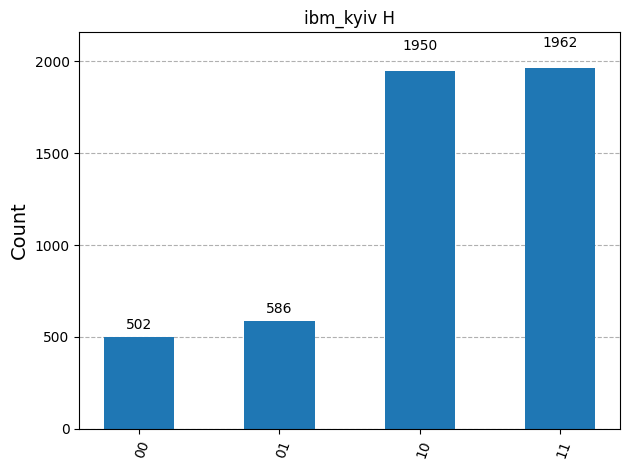

In [38]:
# Extract results
jobB = service.job('czzxtzbd8drg008j5e20')
result = jobB.result()[0]
counts = result.data.meas.get_counts()

# parameters
k = 1;h = 1.5;
n_shots = 5000

# Energies
ene_A = (h**2)/(np.sqrt(h**2+k**2))
ene_B = (h**2)/(np.sqrt(h**2+k**2))

# Error arrays
error_A = []
error_B = []

# Calculate errors
for orig_bit_string, count in counts.items():
        bit_string = orig_bit_string[::-1]

        ene_B += h*(-1)**int(bit_string[1])*count/n_shots
        ene_A += h*(-1)**int(bit_string[0])*count/n_shots

        for i in range(count):
            error_A.append(h*(-1)**int(bit_string[0]))
            error_B.append(h*(-1)**int(bit_string[1]))

# Print results
print("Theoric energy injected by Alice",h**2/np.sqrt(h**2+k**2))
print("Experimental energy injected by Alice",ene_A,"±",np.std(error_A)/np.sqrt(n_shots))
print("Bob's local energy, H_B =",ene_B,"±",np.std(error_B)/np.sqrt(n_shots))

plot_histogram(counts, title=f"{backend.name} H")

### Job Ids list

In [35]:
"""
Circuit V ID = czzxtmtkzhn0008dhhwg h = 1 k = 0.2

Circuit H ID = czzxtpjnhqag008v1a2g h = 1 k = 0.2

Circuit V ID = czzxtrbrxz8g008febe0 h = 1 k = 0.5

Circuit H ID = czzxtt36rr3g008mrang h = 1 k = 0.5

Circuit V ID = czzxtvknhqag008v1a40 h = 1 k = 1

Circuit H ID = czzxtx3nhqag008v1a5g h = 1 k = 1

Circuit V ID = czzxtybnhqag008v1a7g h = 1.5 k = 1

Circuit H ID = czzxtzbd8drg008j5e20 h = 1.5 k = 1
"""

'\nCircuit V ID = czzxtmtkzhn0008dhhwg h = 1 k = 0.2\n\nCircuit H ID = czzxtpjnhqag008v1a2g h = 1 k = 0.2\n\nCircuit V ID = czzxtrbrxz8g008febe0 h = 1 k = 0.5\n\nCircuit H ID = czzxtt36rr3g008mrang h = 1 k = 0.5\n\nCircuit V ID = czzxtvknhqag008v1a40 h = 1 k = 1\n\nCircuit H ID = czzxtx3nhqag008v1a5g h = 1 k = 1\n\nCircuit V ID = czzxtybnhqag008v1a7g h = 1.5 k = 1\n\nCircuit H ID = czzxtzbd8drg008j5e20 h = 1.5 k = 1\n'

## Extra: Initial ground state energy

Interacting energy, V =  0.00028935623730949774 ± 0.0006324543904504102
Alice's local energy, H_A = -0.00010732188134524555 ± 0.00022326690027856794
Bob's local energy, H_B = -0.00010732188134524555 ± 0.00022326690027856794
Alice energy, E_A = 0.0001820343559642522
Bob energy, E_B = 0.0001820343559642522


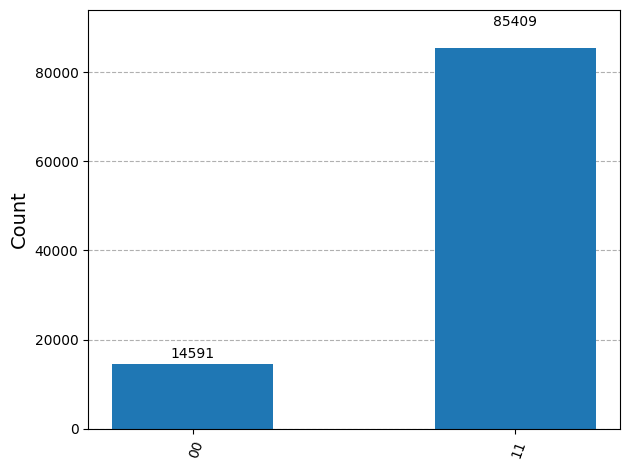

In [36]:
from qiskit_aer.primitives import SamplerV2 as sampler

def qc_V(h,k):

    # Create circuit
    qr = QuantumRegister(2)
    qc = QuantumCircuit(qr)
    
    #Prepare the ground state
    theta = -np.arcsin((1/np.sqrt(2))*(np.sqrt(1+h/np.sqrt(h**2+k**2))))

    qc.ry(2*theta,qr[0])
    qc.cx(qr[0],qr[1])

    # Measure Energies
    qc.h(qr[0])
    qc.h(qr[1])
    qc.measure_all()

    return qc

def qc_H(h,k):

    # Create circuit
    qr = QuantumRegister(2)
    qc = QuantumCircuit(qr)
    
    #Prepare the ground state
    theta = -np.arcsin((1/np.sqrt(2))*(np.sqrt(1+h/np.sqrt(h**2+k**2))))

    qc.ry(2*theta,qr[0])
    qc.cx(qr[0],qr[1])

    # Measure Energies
    qc.measure_all()

    return qc

###################################################################################################################################################################################################

# Initiate simulator
simulator = AerSimulator()

# Parameters
h = 0.1; k = 0.1;
n_shots = 100000

# Generate circuits
qc = qc_V(h, k)
qc_A = transpile(qc, simulator, optimization_level=3)

qc = qc_H(h, k)
qc_B = transpile(qc, simulator, optimization_level=3)

# Run job with Sampler
jobA = sampler().run([qc_A], shots=n_shots)
jobB = sampler().run([qc_B], shots=n_shots)

###################################################################################################################################################################################################

result = jobA.result()[0]
counts = result.data.meas.get_counts()

# Energies
ene_V=(2*k**2)/(np.sqrt(h**2+k**2))

# Erros arrays
error_V=[]

# Calculate energies and errors
for orig_bit_string, count in counts.items():
        bit_string = orig_bit_string[::-1]

        ene_V += 2*k*(-1)**int(bit_string[0])*(-1)**int(bit_string[1])*count/n_shots

        for i in range(count):
            error_V.append(2*k*(-1)**(int(bit_string[1])))

# Print results
print("Interacting energy, V = ",ene_V,"±",np.std(error_V)/np.sqrt(n_shots))

result = jobB.result()[0]
counts = result.data.meas.get_counts()

# Energies
ene_A = (h**2)/(np.sqrt(h**2+k**2))
ene_B = (h**2)/(np.sqrt(h**2+k**2))

# Error arrays
error_A = []
error_B = []

# Calculate errors
for orig_bit_string, count in counts.items():
        bit_string = orig_bit_string[::-1]

        ene_B += h*(-1)**int(bit_string[1])*count/n_shots
        ene_A += h*(-1)**int(bit_string[0])*count/n_shots

        for i in range(count):
            error_A.append(h*(-1)**int(bit_string[0]))
            error_B.append(h*(-1)**int(bit_string[1]))

# Print results
print("Alice's local energy, H_A =",ene_A,"±",np.std(error_A)/np.sqrt(n_shots))
print("Bob's local energy, H_B =",ene_B,"±",np.std(error_B)/np.sqrt(n_shots))

###################################################################################################################################################################################################
print("Alice energy, E_A =", ene_A + ene_V)
print("Bob energy, E_B =", ene_B + ene_V)

plot_histogram(counts)